# Práctica 2: Modelo cinemático inverso de un manipulador y planteamiento de trayectoria

## Objetivo

El objetivo de esta práctica es que el alumno comprenda, interprete y modifique la información básica de los formatos de Universal Robot Description File (URDF).


### Metas 

- Que el alumno aplique un modelo cinemático inverso para calcular una trayectoria a partir de una posición actual hacia una posición final
- Que el alumno grafique y analice los resultados del modelo

### Contribución al perfil del egresado

La siguiente práctica contribuye en los siguientes puntos al perfil del egresado:

#### Aptitudes y habilidades

- Para modelar, simular e interpretar el comportamiento de los sistemas mecatrónicos.
- Para diseñar, construir, operar y mantener los sistemas mecatrónicos y sus componentes.

#### Actitudes

- Tener confianza en su preparación académica.
- Comprometido con su actualización, superación y competencia profesional.

#### De tipo social

- Promover el cambio en la mentalidad frente a la competitividad internacional.

## Rúbrica de evaluación

La evaluación de la práctica contará de los siguientes puntos y se evaluará con los siguientes criterios:

| Elemento | Porcentaje |
| ------:| -----------:|
| **Cuestionario previo** | 15% | 
| **Desarrollo** | 35% |
| **Análisis de resultados**  | 35% |
| **Conclusiones** | 15% |

<br>


| Elemento | Malo | Regular | Bueno |
| ------:| ------ | --------| ------|
| **Cuestionario previo** | El trabajo no contiene cuestionario previo o todas las preguntas son incorrectas (0%)| Al menos la mitad de las preguntas son correctas (8%) |  Todas las preguntas son correctas (15%) |
| **Desarrollo** | El trabajo no contiene desarrollo o su planteamiento no concuerda con lo deseado (0%) | El desarrollo está mal planteado o no llega a los resultados esperados (10%) | El desarrollo tiene un planteamiento adecuado y llega a los resultados esperados (35%) |
| **Análisis de resultados**  | El trabajo no contiene análisis de resultados o la información no se está interpretando correctamente (0%) | La interpretación de los resultados es parcial o desorganizada (10%) | Realiza un correcto análisis de los resultados de forma organizada   (35%) |
| **Conclusiones** | El trabajo no contiene conclusiones o no hacen referencia al trabajo desarrollado y los objetivos planteados (0%) | La redacción de las conclusiones es desorganizada o confusa (8%) | Las conclusiones del trabajo son claras y hacen referencia al trabajo desarrollado y los objetivos planteados (15%) | 



## Introducción

### Transformaciones homogéneas
Las transformaciones homogéneas permiten hacer el planteamiento del modelo cinemático de un robot, considerando las posiciones y orientaciones de las juntas del robot respecto al sistema de referencia de una junta anterior

Este planteamiento es el **modelo de cinemática directa**, que nos permite obtener la posición y velocidad del efector final de un manipulador en términos de los valores de la posición y velocidad de sus juntas (espacio de trabajo)

A través de este modelo se puede obtener el **modelo de cinemática inversa**, que permite obtener la velocidad de las juntas de un robot a partir de la velocidad deseada del efector final.

### Planteamiento de una trayectoria
Si se conoce el punto inicial y final de una trayectoria deseada, se pueden obtener los puntos intermedios de la trayectoria. La forma más fácil de realizar esta interpolación es a través de un spline. El orden del spline permitirá controlar las condiciones inicial y final de la posición, velocidad ó aceleración que tendrá el efector final durante el trayecto. 

Juntando la interpolación de la trayectoria y el modelo de la cinemática inversa, se pueden obtener todos los puntos intermedios de la trayectoria que deben seguir las juntas del robot para que el efector final siga una trayectoria.

## Cuestionario previo

Responder de forma breve las siguientes preguntas:

- ¿Que son las transformaciones homogéneas?
>Respuesta: Son matrices que combinan rotaciones y traslaciones en una sola representación para describir la posición y orientación de un cuerpo en el espacio respecto a un sistema de referencia fijo.

- ¿Que nos permite obtener el modelo de cinemática directa de un manipulador?
>Respuesta

- ¿Que nos permite obtener el modelo de cinemática inversa de un manipulador?
>Respuesta

- ¿De que formas se puede interpolar la trayectoria de un efector final entre dos puntos?
>Respuesta

## Desarrollo

### 1. Planteamiento de la cinemática directa
En esta primera parte, se crearán las transformaciones homogéneas y el modelo de cinemática directa de un robot RRR, incluyendo la matriz del Jacobiano. Se recomienda usar **Sympy** para el planteamiento de las expresiones. 
Un diagrama del robot se muestra en la imagen:

<img src="imagenes/p2_1.png" alt = "Robot RRR" width="300" height="300" display= "block"/>

** Considerar valores cualesquiera para las dimensiones de los eslabones y la posición inicial de las juntas

In [1]:
# Colocar y correr el código dentro de estas celdas. 
# Agregar cuantas consideren conveniente
#!/usr/bin/env python3
from sympy import *
import matplotlib.pyplot as plt
import numpy as np

# Definición de la clase para el robot RRR
class RobotRRR:
    def __init__(self, dim=(0.3, 0.3, 0.3)):
        # Dimensiones de los eslabones del robot
        self.dim = dim
        
    def trans_homo(self, x, y, z, gamma, beta, alpha):
        """
        Genera matriz de transformación homogénea usando ángulos de Euler
        x, y, z: traslación
        gamma: rotación en eje x
        beta: rotación en eje y
        alpha: rotación en eje z
        """
        R_z = Matrix([[cos(alpha), -sin(alpha), 0], 
                      [sin(alpha), cos(alpha), 0],
                      [0, 0, 1]])
        R_y = Matrix([[cos(beta), 0, -sin(beta)], 
                      [0, 1, 0],
                      [sin(beta), 0, cos(beta)]])
        R_x = Matrix([[1, 0, 0], 
                      [0, cos(gamma), -sin(gamma)],
                      [0, sin(gamma), cos(gamma)]])
        
        R = R_x * R_y * R_z
        p = Matrix([[x], [y], [z]])
        T = Matrix.vstack(Matrix.hstack(R, p), Matrix([[0, 0, 0, 1]]))
        return T
    
    def cinematica_directa(self):
        """
        Calcula el modelo de cinemática directa del robot RRR
        """
        print("Generando cinemática directa")
        
        # Definición de las variables simbólicas para los ángulos de las juntas
        self.theta_0_1, self.theta_1_2, self.theta_2_3 = symbols("theta_0_1 theta_1_2 theta_2_3")
        
        # Matrices de transformación homogénea según el convenio DH
        # La primera transformación incluye rotación de pi/2 en el eje x para orientar correctamente el sistema
        self.T_0_1 = self.trans_homo(0, 0, 0, pi/2, 0, self.theta_0_1)
        self.T_1_2 = self.trans_homo(self.dim[0], 0, 0, 0, 0, self.theta_1_2)
        self.T_2_3 = self.trans_homo(self.dim[1], 0, 0, 0, 0, self.theta_2_3)
        self.T_3_P = self.trans_homo(self.dim[2], 0, 0, 0, 0, 0)
        
        # Transformación total desde la base hasta el efector final
        self.T_0_P = simplify(self.T_0_1 * self.T_1_2 * self.T_2_3 * self.T_3_P)
        
        # Vector de postura del efector final (x, z, θ)
        self.xi_0_P = Matrix([
            [self.T_0_P[0, 3]],           # Posición x
            [self.T_0_P[2, 3]],           # Posición z
            [self.theta_0_1 + self.theta_1_2 + self.theta_2_3]]  # Orientación
        )
        
        # Cálculo del Jacobiano
        self.calcular_jacobiano()
        
        return self.T_0_P, self.xi_0_P
    
    def calcular_jacobiano(self):
        """
        Calcula la matriz Jacobiana del robot
        """
        # El Jacobiano relaciona las velocidades de las juntas con la velocidad del efector final
        # J = [∂xi/∂θ₁, ∂xi/∂θ₂, ∂xi/∂θ₃]
        self.J = Matrix.hstack(
            diff(self.xi_0_P, self.theta_0_1),
            diff(self.xi_0_P, self.theta_1_2),
            diff(self.xi_0_P, self.theta_2_3)
        )
        
        # Inversa del Jacobiano (para la cinemática inversa)
        self.J_inv = self.J.inv()
        
        return self.J, self.J_inv
    
    def evaluar_modelo(self, q_values):
        """
        Evalúa el modelo para valores específicos de las juntas
        q_values: tupla con los valores de los ángulos (θ₁, θ₂, θ₃)
        """
        # Sustituye los valores de las juntas en la transformación homogénea
        T_eval = self.T_0_P.subs({
            self.theta_0_1: q_values[0],
            self.theta_1_2: q_values[1],
            self.theta_2_3: q_values[2]
        })
        
        # Sustituye los valores de las juntas en el vector de postura
        xi_eval = self.xi_0_P.subs({
            self.theta_0_1: q_values[0],
            self.theta_1_2: q_values[1],
            self.theta_2_3: q_values[2]
        })
        
        return T_eval, xi_eval

# Ejecución del modelo
def main():
    # Crear instancia del robot con dimensiones de ejemplo
    robot = RobotRRR(dim=(0.3, 0.3, 0.3))
    
    # Calcular el modelo cinemático directo
    T_0_P, xi_0_P = robot.cinematica_directa()
    
    print("Matriz de transformación homogénea de la base al efector final:")
    print(T_0_P)
    
    print("\nVector de postura (x, z, θ):")
    print(xi_0_P)
    
    print("\nMatriz Jacobiana:")
    print(robot.J)
    
    # Evaluar el modelo para una posición específica
    q_test = (pi/4, pi/4, pi/4)  # Ejemplo: todas las juntas a 45 grados
    T_test, xi_test = robot.evaluar_modelo(q_test)
    
    print("\nPara θ₁ = π/4, θ₂ = π/4, θ₃ = π/4:")
    print("Posición del efector final (x, z, θ):")
    print(xi_test)

if __name__ == "__main__":
    main()

Generando cinemática directa
Matriz de transformación homogénea de la base al efector final:
Matrix([[cos(theta_0_1 + theta_1_2 + theta_2_3), -sin(theta_0_1 + theta_1_2 + theta_2_3), 0, 0.3*cos(theta_0_1) + 0.3*cos(theta_0_1 + theta_1_2) + 0.3*cos(theta_0_1 + theta_1_2 + theta_2_3)], [0, 0, -1, 0], [sin(theta_0_1 + theta_1_2 + theta_2_3), cos(theta_0_1 + theta_1_2 + theta_2_3), 0, 0.3*sin(theta_0_1) + 0.3*sin(theta_0_1 + theta_1_2) + 0.3*sin(theta_0_1 + theta_1_2 + theta_2_3)], [0, 0, 0, 1]])

Vector de postura (x, z, θ):
Matrix([[0.3*cos(theta_0_1) + 0.3*cos(theta_0_1 + theta_1_2) + 0.3*cos(theta_0_1 + theta_1_2 + theta_2_3)], [0.3*sin(theta_0_1) + 0.3*sin(theta_0_1 + theta_1_2) + 0.3*sin(theta_0_1 + theta_1_2 + theta_2_3)], [theta_0_1 + theta_1_2 + theta_2_3]])

Matriz Jacobiana:
Matrix([[-0.3*sin(theta_0_1) - 0.3*sin(theta_0_1 + theta_1_2) - 0.3*sin(theta_0_1 + theta_1_2 + theta_2_3), -0.3*sin(theta_0_1 + theta_1_2) - 0.3*sin(theta_0_1 + theta_1_2 + theta_2_3), -0.3*sin(theta_0_1 + 

### 2. Planteamiento de la trayectoria

En esta segunda parte, se planteará el código que permita definir los puntos intermedios de una trayectoria, la cual debe tener velocidades y aceleraciones nulas al inicio y al final. Se deben incluir también las gráficas de la posición, velocidad y aceleración del efector final. 

Calcular la trayectoria considerando de forma general tiempo de duración, puntos inicial y final, y con una tasa de muestreo de 30 muestras por segundo. 

Ejemplo 1
Generando trayectoria suave
Polinomio de interpolación calculado
Muestreando trayectoria
Iteración 0
Iteración 10
Iteración 20
Iteración 30
Iteración 40
Iteración 50
Iteración 60

Verificación de condiciones
Velocidad inicial: x'=0.000000, z'=0.000000, θ'=-0.000000
Velocidad final: x'=0.000000, z'=0.000000, θ'=-0.000000
Aceleración inicial: x''=0.000000, z''=0.000000, θ''=-0.000000
Aceleración final: x''=0.000000, z''=0.000000, θ''=-0.000000


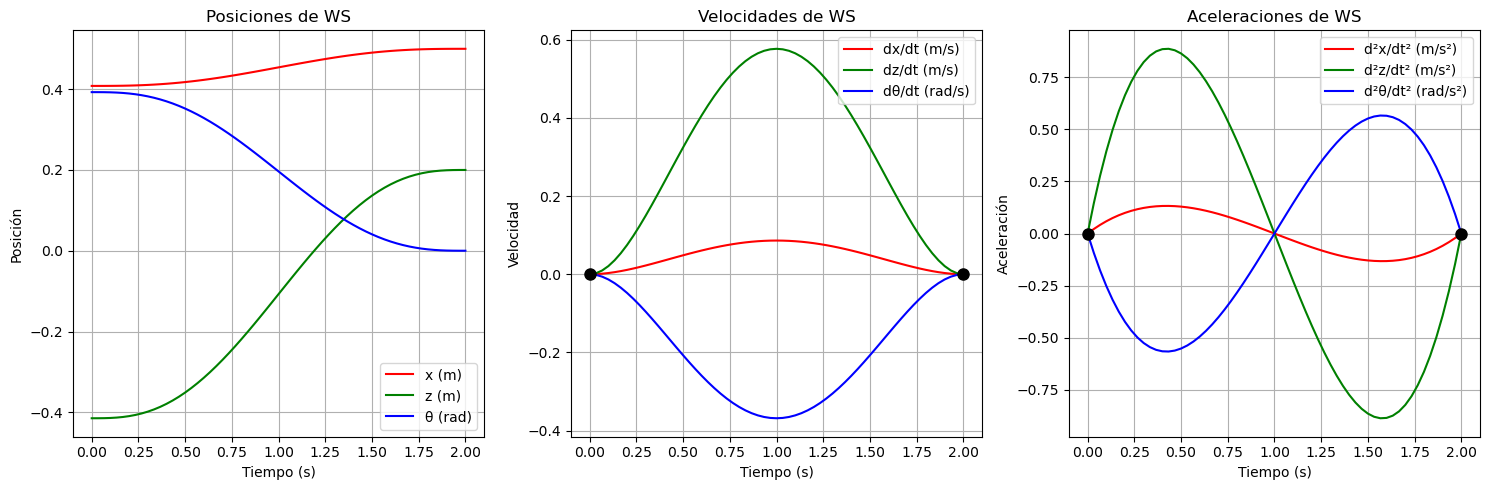

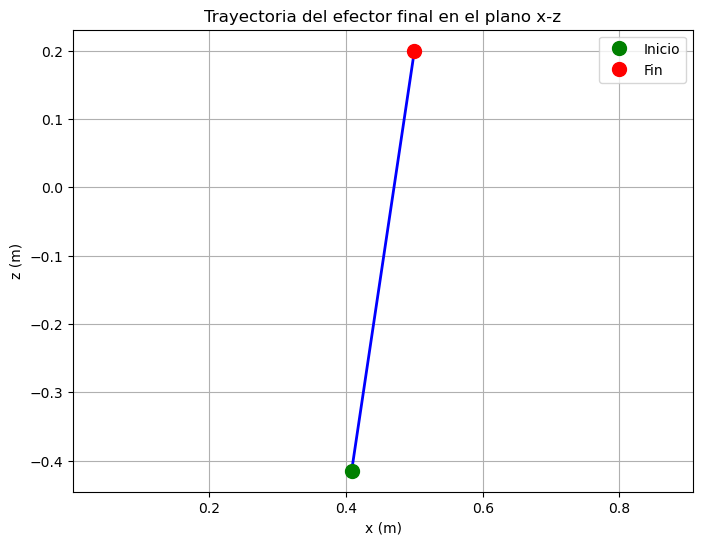

Posición inicial del efector: x=0.408, z=-0.415, θ=0.393
Posición final del efector: x=0.500, z=0.200, θ=0.000
Velocidades máximas: x=0.086 m/s, z=0.576 m/s, θ=0.368 rad/s
Aceleraciones máximas: x=0.133 m/s², z=0.887 m/s², θ=0.567 rad/s²

Ejemplo 2
Generando trayectoria suave
Polinomio de interpolación calculado
Muestreando trayectoria
Iteración 0
Iteración 10
Iteración 20
Iteración 30
Iteración 40
Iteración 50
Iteración 60
Iteración 70
Iteración 80
Iteración 90

Verificación de condiciones
Velocidad inicial: x'=0.000000, z'=0.000000, θ'=0.000000
Velocidad final: x'=0.000000, z'=0.000000, θ'=0.000000
Aceleración inicial: x''=0.000000, z''=0.000000, θ''=0.000000
Aceleración final: x''=0.000000, z''=0.000000, θ''=0.000000


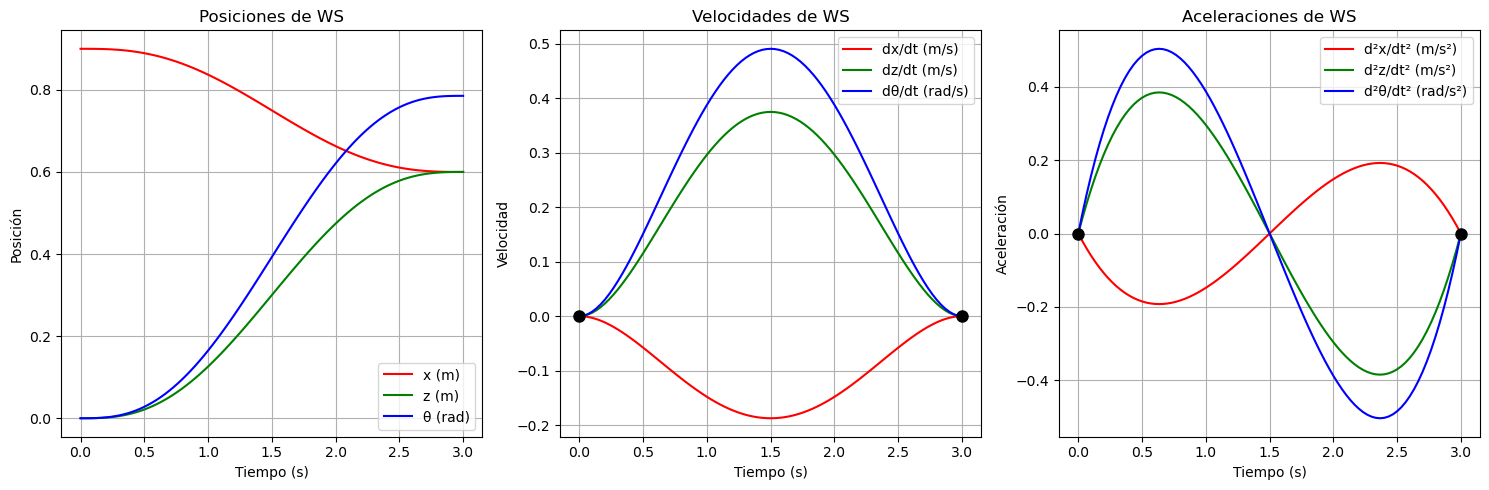

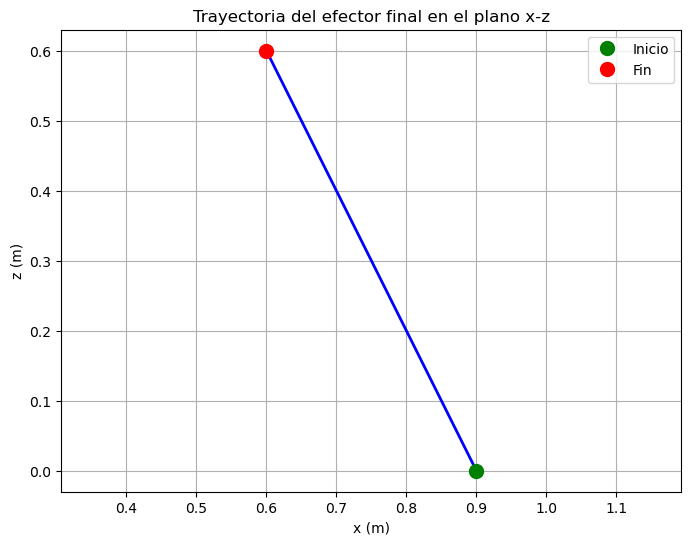

Posición inicial del efector: x=0.900, z=0.000, θ=0.000
Posición final del efector: x=0.600, z=0.600, θ=0.785
Velocidades máximas: x=0.187 m/s, z=0.375 m/s, θ=0.491 rad/s
Aceleraciones máximas: x=0.192 m/s², z=0.385 m/s², θ=0.504 rad/s²


In [30]:
# Colocar y correr el código dentro de estas celdas. 
# Agregar cuantas consideren conveniente
# Celda 2: Generación de trayectoria con velocidades y aceleraciones nulas
# IMPORTANTE: Ejecutar esta celda solo después de ejecutar la Celda 1

def generar_trayectoria_suave(q_inicial, xi_final, tiempo_total=2.0, frecuencia=30):
    """
    Genera una trayectoria suave con velocidades y aceleraciones nulas al inicio y final
    
    Parámetros:
    q_inicial: tupla con ángulos iniciales (θ1, θ2, θ3) en radianes
    xi_final: tupla con posición final del efector (x, z, θ) 
    tiempo_total: duración de la trayectoria en segundos
    frecuencia: muestras por segundo (Hz)
    """
    
    print("Generando trayectoria suave")
    
    # Variables para el tiempo y coeficientes del polinomio
    t = symbols('t')
    a0, a1, a2, a3, a4, a5 = symbols('a0 a1 a2 a3 a4 a5')
    
    # Polinomio de quinto grado para λ(t)
    # λ(t) = a0 + a1*t + a2*t² + a3*t³ + a4*t⁴ + a5*t⁵
    lam = a0 + a1*t + a2*t**2 + a3*t**3 + a4*t**4 + a5*t**5
    
    # Derivadas del polinomio
    lam_dot = diff(lam, t)      # Primera derivada
    lam_dot_dot = diff(lam_dot, t)  # Segunda derivada
    
    # Condiciones de contorno:
    # λ(0) = 0, λ(T) = 1
    # λ'(0) = 0, λ'(T) = 0 
    # λ''(0) = 0, λ''(T) = 0
    condiciones = [
        lam.subs(t, 0),                    # λ(0) = 0
        lam.subs(t, tiempo_total) - 1,     # λ(T) = 1
        lam_dot.subs(t, 0),                # λ'(0) = 0
        lam_dot.subs(t, tiempo_total),     # λ'(T) = 0
        lam_dot_dot.subs(t, 0),            # λ''(0) = 0
        lam_dot_dot.subs(t, tiempo_total)  # λ''(T) = 0
    ]
    
    # Resolver el sistema para obtener los coeficientes
    coeficientes = solve(condiciones, [a0, a1, a2, a3, a4, a5])
    
    # Sustituir los coeficientes en las expresiones
    lam_final = lam.subs(coeficientes)
    lam_dot_final = lam_dot.subs(coeficientes)
    lam_dot_dot_final = lam_dot_dot.subs(coeficientes)
    
    print("Polinomio de interpolación calculado")
    
    # Calcular posición inicial del efector final
    xi_inicial = xi.subs([(theta1, q_inicial[0]), (theta2, q_inicial[1]), (theta3, q_inicial[2])])
    
    # Trayectoria del efector final
    # Posición: ξ(t) = ξ_inicial + λ(t) * (ξ_final - ξ_inicial)
    x_traj = xi_inicial[0] + lam_final * (xi_final[0] - xi_inicial[0])
    z_traj = xi_inicial[1] + lam_final * (xi_final[1] - xi_inicial[1])
    theta_traj = xi_inicial[2] + lam_final * (xi_final[2] - xi_inicial[2])
    
    # Velocidad: ξ'(t) = λ'(t) * (ξ_final - ξ_inicial)
    x_dot_traj = lam_dot_final * (xi_final[0] - xi_inicial[0])
    z_dot_traj = lam_dot_final * (xi_final[1] - xi_inicial[1])
    theta_dot_traj = lam_dot_final * (xi_final[2] - xi_inicial[2])
    
    # Aceleración: ξ''(t) = λ''(t) * (ξ_final - ξ_inicial)
    x_ddot_traj = lam_dot_dot_final * (xi_final[0] - xi_inicial[0])
    z_ddot_traj = lam_dot_dot_final * (xi_final[1] - xi_inicial[1])
    theta_ddot_traj = lam_dot_dot_final * (xi_final[2] - xi_inicial[2])
    
    # Muestreo de la trayectoria
    n_muestras = int(frecuencia * tiempo_total + 1)
    dt = tiempo_total / (n_muestras - 1)
    
    # Arrays para almacenar los valores
    tiempo_vec = np.linspace(0, tiempo_total, n_muestras)
    
    # Convertir expresiones simbólicas a funciones numéricas
    x_func = lambdify(t, x_traj, 'numpy')
    z_func = lambdify(t, z_traj, 'numpy')
    theta_func = lambdify(t, theta_traj, 'numpy')
    
    x_dot_func = lambdify(t, x_dot_traj, 'numpy')
    z_dot_func = lambdify(t, z_dot_traj, 'numpy')
    theta_dot_func = lambdify(t, theta_dot_traj, 'numpy')
    
    x_ddot_func = lambdify(t, x_ddot_traj, 'numpy')
    z_ddot_func = lambdify(t, z_ddot_traj, 'numpy')
    theta_ddot_func = lambdify(t, theta_ddot_traj, 'numpy')
    
    # Evaluar las funciones con contador de iteraciones
    x_vals = x_func(tiempo_vec)
    z_vals = z_func(tiempo_vec)
    theta_vals = theta_func(tiempo_vec)
    
    x_dot_vals = x_dot_func(tiempo_vec)
    z_dot_vals = z_dot_func(tiempo_vec)
    theta_dot_vals = theta_dot_func(tiempo_vec)
    
    x_ddot_vals = x_ddot_func(tiempo_vec)
    z_ddot_vals = z_ddot_func(tiempo_vec)
    theta_ddot_vals = theta_ddot_func(tiempo_vec)
    
    # Mostrar progreso de iteraciones
    print("Muestreando trayectoria")
    for i in range(n_muestras):
        if i % 10 == 0 or i == n_muestras - 1:
            print(f"Iteración {i}")
    
    # Verificar condiciones iniciales y finales
    print("\nVerificación de condiciones")
    print(f"Velocidad inicial: x'={x_dot_vals[0]:.6f}, z'={z_dot_vals[0]:.6f}, θ'={theta_dot_vals[0]:.6f}")
    print(f"Velocidad final: x'={x_dot_vals[-1]:.6f}, z'={z_dot_vals[-1]:.6f}, θ'={theta_dot_vals[-1]:.6f}")
    print(f"Aceleración inicial: x''={x_ddot_vals[0]:.6f}, z''={z_ddot_vals[0]:.6f}, θ''={theta_ddot_vals[0]:.6f}")
    print(f"Aceleración final: x''={x_ddot_vals[-1]:.6f}, z''={z_ddot_vals[-1]:.6f}, θ''={theta_ddot_vals[-1]:.6f}")
    
    # Generar gráficas
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Gráfica de posición
    axes[0].set_title("Posiciones de WS")
    axes[0].plot(tiempo_vec, x_vals, color="RED", label='x (m)')
    axes[0].plot(tiempo_vec, z_vals, color="GREEN", label='z (m)')
    axes[0].plot(tiempo_vec, theta_vals, color="BLUE", label='θ (rad)')
    axes[0].set_xlabel('Tiempo (s)')
    axes[0].set_ylabel('Posición')
    axes[0].legend()
    axes[0].grid(True)
    
    # Gráfica de velocidad
    axes[1].set_title("Velocidades de WS")
    axes[1].plot(tiempo_vec, x_dot_vals, color="RED", label='dx/dt (m/s)')
    axes[1].plot(tiempo_vec, z_dot_vals, color="GREEN", label='dz/dt (m/s)')
    axes[1].plot(tiempo_vec, theta_dot_vals, color="BLUE", label='dθ/dt (rad/s)')
    axes[1].set_xlabel('Tiempo (s)')
    axes[1].set_ylabel('Velocidad')
    axes[1].legend()
    axes[1].grid(True)
    
    # Marcar puntos inicial y final con círculos negros
    axes[1].plot(tiempo_vec[0], 0, 'ko', markersize=8)
    axes[1].plot(tiempo_vec[-1], 0, 'ko', markersize=8)
    
    # Gráfica de aceleración
    axes[2].set_title("Aceleraciones de WS")
    axes[2].plot(tiempo_vec, x_ddot_vals, color="RED", label='d²x/dt² (m/s²)')
    axes[2].plot(tiempo_vec, z_ddot_vals, color="GREEN", label='d²z/dt² (m/s²)')
    axes[2].plot(tiempo_vec, theta_ddot_vals, color="BLUE", label='d²θ/dt² (rad/s²)')
    axes[2].set_xlabel('Tiempo (s)')
    axes[2].set_ylabel('Aceleración')
    axes[2].legend()
    axes[2].grid(True)
    
    # Marcar puntos inicial y final con círculos negros
    axes[2].plot(tiempo_vec[0], 0, 'ko', markersize=8)
    axes[2].plot(tiempo_vec[-1], 0, 'ko', markersize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Gráfica adicional: Trayectoria en el plano x-z
    plt.figure(figsize=(8, 6))
    plt.plot(x_vals, z_vals, 'b-', linewidth=2)
    plt.plot(x_vals[0], z_vals[0], 'go', markersize=10, label='Inicio')
    plt.plot(x_vals[-1], z_vals[-1], 'ro', markersize=10, label='Fin')
    plt.xlabel('x (m)')
    plt.ylabel('z (m)')
    plt.title('Trayectoria del efector final en el plano x-z')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.show()
    
    # Estadísticas finales (mantener intacto según solicitud)
    print("Posición inicial del efector: x={:.3f}, z={:.3f}, θ={:.3f}".format(float(xi_inicial[0]), float(xi_inicial[1]), float(xi_inicial[2])))
    print("Posición final del efector: x={:.3f}, z={:.3f}, θ={:.3f}".format(float(xi_final[0]), float(xi_final[1]), float(xi_final[2])))
    print("Velocidades máximas: x={:.3f} m/s, z={:.3f} m/s, θ={:.3f} rad/s".format(np.max(np.abs(x_dot_vals)), np.max(np.abs(z_dot_vals)), np.max(np.abs(theta_dot_vals))))
    print("Aceleraciones máximas: x={:.3f} m/s², z={:.3f} m/s², θ={:.3f} rad/s²".format(np.max(np.abs(x_ddot_vals)), np.max(np.abs(z_ddot_vals)), np.max(np.abs(theta_ddot_vals))))
    
    return {
        'tiempo': tiempo_vec,
        'posicion': (x_vals, z_vals, theta_vals),
        'velocidad': (x_dot_vals, z_dot_vals, theta_dot_vals),
        'aceleracion': (x_ddot_vals, z_ddot_vals, theta_ddot_vals),
        'xi_inicial': xi_inicial,
        'xi_final': xi_final
    }

# Ejemplo de uso
print("Ejemplo 1")
# Configuración inicial de las juntas
q_inicial = (pi/4, -pi/2, 3*pi/8)  # θ1=45°, θ2=-90°, θ3=67.5°

# Posición final deseada del efector
xi_final = (0.5, 0.2, 0)  # x=0.5m, z=0.2m, θ=0rad

# Generar trayectoria
resultado1 = generar_trayectoria_suave(q_inicial, xi_final, tiempo_total=2.0, frecuencia=30)

print("\nEjemplo 2")
# Otro ejemplo con parámetros diferentes
q_inicial2 = (0, 0, 0)  # Configuración inicial diferente
xi_final2 = (0.6, 0.6, pi/4)  # Posición final diferente

resultado2 = generar_trayectoria_suave(q_inicial2, xi_final2, tiempo_total=3.0, frecuencia=30)

### 3. Cinemática inversa
A partir del modelo de la cinemática directa, obtener la expresión e la cinemática inversa, que relacione las velocidades de las juntas del robot con la velocidad del efector final. Ya que el modelo de cinemática inversa sólo permite obtener velocidades, obtener también expresiones que permitan obtener la posición de las juntas y sus aceleraciones

In [ ]:
# Colocar y correr el código dentro de estas celdas. 
# Agregar cuantas consideren conveniente

### 4. Aplicación de la cinemática inversa
Finalmente, a partir de los puntos de la trayectoria y el modelo de cinemática inversa, obtener las posiciones, velocidades y aceleraciones de las juntas del robot, así como sus gráficas en función del tiempo

In [ ]:
# Colocar y correr el código dentro de estas celdas. 
# Agregar cuantas consideren conveniente

### 5. Aplicación de la cinemática inversa
Para terminar, subir los archivos de la práctica al repositorio de github

## Análisis de resultados

- ¿Qué utilidad tuvo usar el modelo de cinemática inversa de un robot?
> Respuesta

- ¿Qué utilidad tiene el modelo de cinemática inversa de un robot?
> Respuesta

- ¿Qué utilidad tiene el modelo de cinemática inversa de un robot?
> Respuesta




## Conclusiones

> Respuesta

## Bibliografía 

> En caso de usarse, se deben hacer referencia a la información implementada en formato ieee


